In [1]:
from __future__ import division

from pylab import *
import scipy
import time
import utils
import hrr_utils

#import imnet_utils as imut
import sklearn
from sklearn.decomposition import PCA, FastICA, TruncatedSVD, NMF

%matplotlib inline

plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rcParams.update({'axes.labelsize': 'xx-large'})
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'})
plt.rcParams.update({'legend.fontsize': 'x-large'})
plt.rcParams.update({'text.usetex': True})



In [82]:
def ngram_encode(ngram_str, letter_vecs, alph):
    vec = np.zeros(letter_vecs.shape[1])
    
    full_str = '#' + ngram_str + '.'
    
    
    for il, l in enumerate(full_str[:-2]):
        trivec = letter_vecs[alph.find(full_str[il]), :]
        for c3 in range(1, 3):
            trivec = trivec * np.roll(letter_vecs[alph.find(full_str[il+c3]), :], c3)
            
        vec += trivec
    return vec

def ngram_encode_cl(ngram_str, letter_vecs, alph):
    vec = ngram_encode(ngram_str, letter_vecs, alph)
    
    return 2* (vec + 0.1*(np.random.rand(letter_vecs.shape[1])-0.5) > 0) - 1

def bind(past, present):
    return np.multiply(past, present)

def reg_bind(past, present):
    pred = np.multiply(tv, present)
    return ((N-sim(pred, past))/float(N)) * np.multiply(past, present)

def bind_diff(past2, present1, present2):
    return np.multiply(present1, past2-present2)

def reg_bind_diff(past2, present1, present2):
    pred = np.multiply(tv, present1) + present2
    return ((N-sim(pred, past2))/float(N)) * np.multiply(past2-present2, present1)

def closed_bind(past, present):
    return np.dot(np.linalg.pinv(present), past)

def sim(x, y):
    if len(x.shape) == 1 or len(y.shape)==1:
        return np.dot(x, y)
    return np.sum(np.multiply(x, y), axis=1)

In [83]:
def state_setup(state_length, letter_vecs, N, D, n_steps):
    states = []
    coef_hists = []
    
    for i in range(state_length):
        states.append(np.random.randn(N))
    
    for i in range(1, state_length-1):
        states[i] = np.dot(letter_vecs.T, np.dot(states[i], letter_vecs.T))

    for i in range(1, state_length-1):
        states[i] = states[i]/norm(states[i])

    states[0] = letter_vecs[alph.find('#'), :]
    states[state_length-1] = letter_vecs[alph.find('.'), :]
    
    for i in range(1, state_length-1):
        coef_hists.append(np.zeros((n_steps, D)))
    
    return states, coef_hists

def iterate(states, coef_hists, state_length, letter_vecs, N, D, n_steps):
    for i in range(n_steps):
        for j in range(1, state_length-1):
            coef_hists[j-1][i, :] = np.dot(letter_vecs, states[j])
            ## Need to make sure that the largest absolute value is always positive,
            ## because the unbinding inference can flip 2 and be the same

            mxidx = np.argmax(np.abs(coef_hists[j-1][i,:]))
            states[j] *= np.sign(coef_hists[j-1][i, mxidx])
            
            if j == 1:
                ljd = (np.roll(bound_vec * states[0] * np.roll(states[j+1], 2), -1) +
                  bound_vec * np.roll(states[j+1], 1) * np.roll(states[j+2], 2)) / 2
            elif 1 < j < state_length-2:
                ljd = (np.roll(bound_vec * states[j-2] * np.roll(states[j-1], 1), -2) +
                    np.roll(bound_vec * states[j-1] * np.roll(states[j+1], 2), -1) +
                      bound_vec * np.roll(states[j+1], 1) * np.roll(states[j+2], 2)) / 3
            else:
                ljd = (np.roll(bound_vec * states[j-1] * np.roll(states[j+1], 2), -1) +
                   np.roll(bound_vec * states[j-2] * np.roll(states[j-1], 1), -2)) / 2

            states[j] = np.dot(letter_vecs.T, np.dot(ljd, letter_vecs.T)/N)
            states[j] = states[j]/norm(states[j])

    return states, coef_hists

In [107]:
alph = 'abcdefghijklmnopqrstuvwxyz#.'

N = 3000
D = len(alph)

letter_vecs = 2 * (np.random.randn(D, N) < 0) - 1


word_key = 2 * (np.random.randn(N) < 0) - 1

#ngram_strs = ['pax', 'max', 'the', 'run', 'ran', 'fun', 'fan', 'top', 'pop', 'off', 'cup', 'cap', 'rap', 'pup', 'pan', 'pun']
#ngram_strs = ['pax', 'max', 'the']
ngram_strs = ['run', 'ran', 'walk', 'walked', 'watch', 'watched', 'catch', 'caught']

bound_vec = np.zeros(N)

word_length = 6
unbind_idx = 3

n_steps = 100

In [108]:
# unregularized bind
for istr, ngram_str in enumerate(ngram_strs):
    vv = ngram_encode_cl(ngram_str, letter_vecs, alph)
    bound_vec += np.roll(word_key, istr) * vv

In [109]:
# regularized bind
for istr, ngram_str in enumerate(ngram_strs):
    vv = ngram_encode_cl(ngram_str, letter_vecs, alph)
    pred = np.multiply(bound_vec, vv)
    bound_vec += np.roll(word_key, istr) * vv * ((N-sim(pred, vv))/float(N))

In [110]:
# # difference bind
# def bind_diff(past2, present1, present2):
#     return np.multiply(present1, past2-present2)

In [111]:
bound_vec = np.roll(word_key, unbind_idx) * bound_vec

In [112]:
states, coef_hists = state_setup(word_length+2, letter_vecs, N, D, n_steps)
states, coef_hists = iterate(states, coef_hists, word_length+2, letter_vecs, N, D, n_steps)

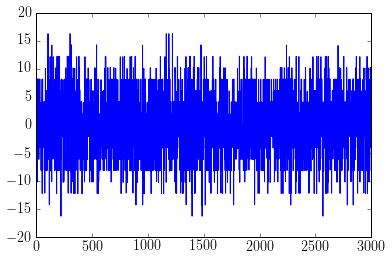

In [113]:
plot(bound_vec)

walked


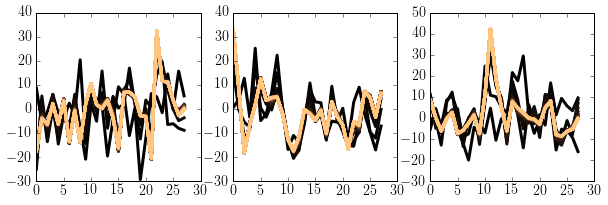

In [114]:
figure(figsize=(10,3))
cols = get_cmap('copper', min(50,n_steps))
for i in range(min(50,n_steps)):
    subplot(131)
    plot(coef_hists[0][i,:], lw=3, c=cols(i))
    subplot(132)
    plot(coef_hists[1][i,:], lw=3, c=cols(i))
    subplot(133)
    plot(coef_hists[2][i,:], lw=3, c=cols(i))
    
pred = ''
for i in range(len(coef_hists)):
    pred += alph[np.argmax(np.abs(coef_hists[i][-1,:]))]

print pred

In [18]:
def encode(past, present, dic1, dic2, ngram_length=3):
    past1 = hrr_utils.GetRVClipHash(past, dic1, ngram_length)
    past2 = hrr_utils.GetRVClipHash(past, dic2, ngram_length)
    pres1 = hrr_utils.GetRVClipHash(present, dic1, ngram_length)
    pres2 = hrr_utils.GetRVClipHash(present, dic2, ngram_length)
    #X = np.where(PAST1-PRES1 > 0, 1, -1)
    return past1, pres1, past2, pres2

def ngram_encode(ngram_str, letter_vecs, alph, window=3):
    vec = np.zeros(letter_vecs.shape[1])
    
    full_str = '#' + ngram_str + '.'
    
    
    for il, l in enumerate(full_str[:-(window-1)]):
        trivec = letter_vecs[alph.find(full_str[il]), :]
        for c3 in range(1, window):
            trivec = trivec * np.roll(letter_vecs[alph.find(full_str[il+c3]), :], c3)
            
        vec += trivec
    return vec

def ngram_encode_cl(ngram_str, letter_vecs, alph, window=3):
    vec = np.zeros(letter_vecs.shape[1])
    
    full_str = '#' + ngram_str + '.'
    
    for il, l in enumerate(full_str[:-(window-1)]):
        trivec = letter_vecs[alph.find(full_str[il]), :]
        for c3 in range(1, window):
            trivec = trivec * np.roll(letter_vecs[alph.find(full_str[il+c3]), :], c3)
            
        vec += trivec
    return 2* (vec + 0.1*(np.random.rand(letter_vecs.shape[1])-0.5) < 0) - 1
   


In [37]:
alph = 'abcdefghijklmnopqrstuvwxyz#.'

N = 1000
D = len(alph)
n_steps = 100
letter_vecs = 2 * (np.random.randn(D, N) < 0) - 1

dic1 = hrr_utils.GenerateDefaultDictionary(N)
dic2 = hrr_utils.GenerateDefaultDictionary(N)

In [15]:
def ngram_encode_train(ngram_strs, encode):
    psi = np.zeros(N)
    for i in range(len(ngram_strs)):
        psi += encode(ngram_strs[i], letter_vecs, alph)
    return psi

def train(past, present, bind):
    psi = np.zeros(N)
    for i in range(len(past)):
        psi += bind(past[i], present[i])
    return psi

def diff_train(past2, present1, present2, bind):
    psi = np.zeros(N)
    for i in range(len(past2)):
        psi += bind(past2[i], present1[i], present2[i])
    return psi

def predict_coefs(n_steps, ngram_str, bound_vec):
    l_states = np.random.randn(len(ngram_str)+2, N)
    for i in range(1,l_states.shape[0]-1):
        l_states[i] = np.dot(letter_vecs.T, np.dot(l_states[i], letter_vecs.T))
        l_states[i] = l_states[i]/norm(l_states[i])

    l_states[0] = letter_vecs[alph.find('#'), :]
    l_states[l_states.shape[0]-1] = letter_vecs[alph.find('.'), :]

    l_coef_hists = np.zeros((n_steps, l_states.shape[0], D))
    for i in range(n_steps):
        for j in range(1,l_states.shape[0]-1):
            l_coef_hists[i, j, :] = np.dot(letter_vecs, l_states[j])

            ## Need to make sure that the largest absolute value is always positive,
            ## because the unbinding inference can flip 2 and be the same

            mxjidx = np.argmax(np.abs(l_coef_hists[i, j, :]))
            l_states[j] *= np.sign(l_coef_hists[i, j, mxjidx])
            if j == 1:
                ljd = (np.roll(bound_vec * l_states[j-1] * np.roll(l_states[j+1], 2), -1) +
                  bound_vec * np.roll(l_states[j+1], 1) * np.roll(l_states[j+2], 2))
            elif 1 < j < l_states.shape[0]-2:
                ljd = (np.roll(bound_vec * l_states[j-2] * np.roll(l_states[j-1], 1), -2) +
                    np.roll(bound_vec * l_states[j-1] * np.roll(l_states[j+1], 2), -1) +
                        bound_vec * np.roll(l_states[j+1], 1) * np.roll(l_states[j+2], 2))
            else:
                ljd = (np.roll(bound_vec * l_states[j-1] * np.roll(l_states[j+1], 2), -1) +
                       np.roll(bound_vec * l_states[j-2] * np.roll(l_states[j-1], 1), -2))

            l_states[j] = np.dot(letter_vecs.T, np.dot(ljd, letter_vecs.T))
            l_states[j] = l_states[j]/norm(l_states[j])
    return l_states, l_coef_hists

def graph(n_steps, l_coef_hists):
    figure(figsize=(10,3))
    cols = get_cmap('copper', n_steps)
    for i in range(n_steps):
        for j in range(1,l_coef_hists.shape[1]-1):
            subplot(130+j)
            plot(abs(l_coef_hists[i,j,:]), lw=3, c=cols(i))
    
def predict(l_coef_hists):
    prediction = ""
    for i in range(1,l_coef_hists.shape[1]-1):
        prediction += alph[np.argmax(abs(l_coef_hists[-1,i,:]))]
    print prediction

In [9]:
# testing noise tolerance
# does this mean that bound vec specific to a word 
# has the same dot product for every correct pair????
#ngram_str = 'banana'#'the'
ngram_str = 'the'
train_set = ['the', 'fam', 'sailboat', 'nuclear', 'compulsive', 'whatisthis']
ngram_vecs = [ngram_encode_cl(verb, letter_vecs, alph) for verb in train_set]
psi = ngram_encode_train(train_set, ngram_encode)
similarities = np.zeros(len(train_set)**2)

#figure()
for i in range(len(ngram_vecs)):
    bound_vec = psi*ngram_vecs[i]
    bound_vec = 2* (bound_vec + 0.1*(np.random.rand(letter_vecs.shape[1])-0.5) < 0) - 1
    #print bound_vec
    for j in range(len(ngram_vecs)):
        #if i == j:
        similarities[i+j] = bound_vec.dot(ngram_vecs[j])
        #print (train_set[i], train_set[j], similarities[i+j])
#plot(similarities)

In [49]:
#ngram_str = 'banana'#'the'
past = ['ran', 'walked']
present = ['run', 'walk']
past1, pres1, past2, pres2 = [], [], [], []
for i in range(len(past)):
    pa1, pr1, pa2, pr2 = encode(past[i], present[i], dic1, dic2, ngram_length=3)
    print (pa1.shape, pr2.shape, pa2.shape, pr2.shape)
    past1.append(pa1)
    pres1.append(pr1)
    past2.append(pa2)
    pres2.append(pr2)
    
#psi = ngram_encode_train(['banana'], ngram_encode)
psis = [
    train(past1, pres1, bind),
    diff_train(past2, pres1, pres2, bind_diff),
]

ngram_str = past[1]
bound_vec = psi[1]
#bound_vec = psis[0]*pres1[1]
#bound_vec = 2* (bound_vec + 0.1*(np.random.rand(letter_vecs.shape[1])-0.5) < 0) - 1

l_states, l_coef_hists = predict_coefs(n_steps, ngram_str, bound_vec)
#graph(n_steps, l_coef_hists)
predict(l_coef_hists)

((1000,), (1000,), (1000,), (1000,))
((1000,), (1000,), (1000,), (1000,))
iqsqvc
